# Identification de communautés
*Ziru Niu et Jiale NING*

## Construction et visualisation du graphe  

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pylab as pl
import scipy.stats as sps
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from scipy.special import comb
import random
import time

### La visualisation du graphe

In [ ]:
# tous les code dans ce block sert a representer le graphe 
# Pour le but de bien separer les communites differentes
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]*2

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    
    g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)

    nx.draw(g, pos, node_color=list(partition.values())); plt.show()
    return

###La construction du graphe
On s'intéresse plutôt au cas où il y a deux communautés. On a écrit une fonction pour évaluer le niveau de différence entre $p_{in}$ et $p_{out}$. Voir le block suivant pour plus de détailles.

In [ ]:
# On choisit nos paramètres
N = int(100) # 
n = 50 # nombre d'individus au total
k = 2 # nombre de communautés
p = 0.5 # pour k = 2, on sépare les individus en deux groupes de taille p*n et n*(1-p) respectivement
c_in = 35 # la proba telle que deux individus du même groupe se connaissent
c_out = 20 # la proba telle que deux individus du différent groupe se connaissent
node = np.arange(0,n) # les indices des individus de 0 à n-1

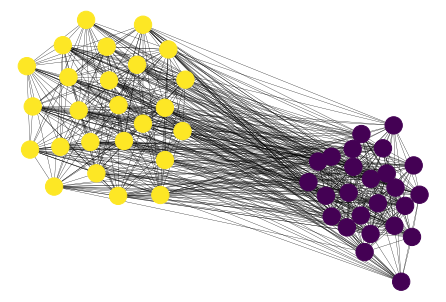

In [ ]:
# La fonction qui caractérise le niveau du modèle
# Le model avec un niveau plus grand serait plus difficile de se faire regrouper 
def niveau():
  return (c_in-c_out)/np.sqrt(np.log(n)*(c_in+c_out))

# La fonction G nous donne un graphe à partir des paramètres
# p est la proportion d'un des ensembles du graphe
def Graphe_(p_,c_in_,c_out_,n_):
  node = np.arange(0,n_)
  G = nx.Graph()
  G.add_nodes_from(node)
  taille1_ = int(n_*p_)
  X1 = sps.bernoulli.rvs(c_in_/n_,size = comb(n_,2,True))
  X2 = X1[comb(taille1_,2,True):]
  X3 = sps.bernoulli.rvs(c_out_/n_, size = taille1_*(n_-taille1_))
  count1 = 0
  count2 = 0
  count3 = 0

  # generate the edges
  for i in node[0:taille1_]:
    for j in node[i+1:taille1_]:
      if (X1[count1]==1): 
        G.add_edge(i,j)
      count1 = count1+1

  for i in node[taille1_:]:
    for j in node[i+1:]:
      if (X2[count2]==1): 
        G.add_edge(i,j)
      count2 = count2+1

  for i in node[0:taille1_]:
    for j in node[taille1_:]:
      if (X3[count3]==1): 
        G.add_edge(i,j)
      count3 = count3+1
  return G

def Graphe(X_,Y_):
  G = nx.Graph()
  G.add_nodes_from(node)
  X1 = X_
  X2 = X_[comb(taille1,2,True):]
  X3 = Y_
  count1 = 0
  count2 = 0
  count3 = 0
  # generate the edges
  for i in node[0:taille1]:
    for j in node[i+1:taille1]:
      if (X1[count1]==1): 
        G.add_edge(i,j)
      count1 = count1+1

  for i in node[taille1:]:
    for j in node[i+1:]:
      if (X2[count2]==1): 
        G.add_edge(i,j)
      count2 = count2+1

  for i in node[0:taille1]:
    for j in node[taille1:]:
      if (X3[count3]==1): 
        G.add_edge(i,j)
      count3 = count3+1
  return G

# La fonction drawG nous donne une visualisation du graphe G
def drawG(G_):
  partition_G = {i:0 for i in range(n)}
  for i in node[int(n*p):]:
    partition_G[i] = 1
  # draw the graphe
  pos = community_layout(G_, partition_G)
  nx.draw(G_, pos, node_color=list(partition_G.values()), width = 0.3)
  plt.show()

G = Graphe_(p,c_in,c_out,n)
drawG(G)

In [ ]:
# Unnormalized spectral clustering
def UnnormSC(k_,G_):
  A = nx.adjacency_matrix(G_)
  W = A.toarray()
  D = np.identity(n)
  for i in range(n):
    D[i][i] = G_.degree(i)
  L = D - W
  eig,v = np.linalg.eig(L) # valeur propre de L
  sorted_indices = np.argsort(eig) # on prend les k (= 2) plus petits valeurs propres
  U = v[:,sorted_indices[:k_]]
  clusters = KMeans(n_clusters=k_,random_state=1).fit_predict(U) # k-means clustering
  return clusters

# Normalized spectral clustering
def NormSC(k_,G_):
  A = nx.adjacency_matrix(G_)
  W = A.toarray()
  D = np.identity(n)
  for i in range(n):
    D[i][i] = G_.degree(i)
  L = D - W
  L_norm = np.matrix(sqrtm(D)).I.dot(L.dot(np.matrix(sqrtm(D)).I))
  eig,v = np.linalg.eig(L_norm) # valeur propre de L_norm
  sorted_indices = np.argsort(eig) # on prend les k (= 2) plus petits valeurs propres
  U = v[:,sorted_indices[:k_]]
  clusters = KMeans(n_clusters=k_,random_state=1).fit_predict(U) # k-means clustering
  return clusters

In [ ]:
# temps de calculs de la matrice U

time_start=time.time()
for j in range(100):
  G = Graphe_(p,c_in,c_out,n)
  A = nx.adjacency_matrix(G)
  W = A.toarray()
  D = np.identity(n)
  for i in range(n):
    D[i][i] = G.degree(i)
  L = D - W
  eig,v = np.linalg.eig(L) # valeur propre de L
  sorted_indices = np.argsort(eig) # on prend les k (= 2) plus petits valeurs propres
  U = v[:,sorted_indices[:k]]
  time_end=time.time()
print('time cost for calculating the matrix U in unnormalized clustering',time_end-time_start,'s')

time_start=time.time()
for j in range(100):
  G = Graphe_(p,c_in,c_out,n)
  A = nx.adjacency_matrix(G)
  W = A.toarray()
  D = np.identity(n)
  for i in range(n):
    D[i][i] = G.degree(i)
  L = D - W
  L_norm = np.matrix(sqrtm(D)).I.dot(L.dot(np.matrix(sqrtm(D)).I)) # normaliser la matrice L
  eig,v = np.linalg.eig(L_norm) # valeur propre de L_norm
  sorted_indices = np.argsort(eig)
  U = v[:,sorted_indices[:k]]
time_end=time.time()
print('time cost for calculating the matrix U in normalized clustering',time_end-time_start,'s')

## test de k-means
time_start=time.time()
for i in range(100):
  clusters = KMeans(n_clusters=k,random_state=1).fit_predict(U)
time_end=time.time()
print('time cost for k-means',time_end-time_start,'s')

time cost for calculating the matrix U in unnormalized clustering 0.5034754276275635 s
time cost for calculating the matrix U in normalized clustering 2.601623296737671 s
time cost for k-means 1.610311508178711 s


In [ ]:
# nombre d'erreurs (fiabilité) dans le cas où k=2(cela ne marche pas pour k>= 2)
# essaie de adjuster la taille
def Nbr_err_unnorm(Graphe):
  clusters = UnnormSC(k,Graphe)
  num_erreurs=0
  for i in range(n):
    if (clusters[i]==0 and i>int(n*p-1)):
      num_erreurs = num_erreurs+1
    elif (clusters[i]==1 and i<=int(n*p-1)):
      num_erreurs = num_erreurs+1
  num_erreurs = np.min((num_erreurs,n-num_erreurs))
  return num_erreurs

def Nbr_err_norm(Graphe):
  clusters = NormSC(k,Graphe)
  num_erreurs=0
  for i in range(n):
    if (clusters[i]==0 and i>int(n*p-1)):
      num_erreurs = num_erreurs+1
    elif (clusters[i]==1 and i<=int(n*p-1)):
      num_erreurs = num_erreurs+1
  num_erreurs = np.min((num_erreurs,n-num_erreurs))
  return num_erreurs

###La estimation de nombre d'erreur et la comparaison entre ces deux méthodes

In [ ]:
N = int(100)
n = 50
k = 2
p = 0.5
c_in = 35
c_out = 20
node = np.arange(0,n)

# l'esperance du nombre d'erreurs par la methode de monte-carlo
err = []
err1 = []
for i in range(N):
  G = Graphe_(p,c_in,c_out,n)
  err.append(Nbr_err_unnorm(G))
  err1.append(Nbr_err_norm(G))

proba = np.mean(err)
proba1 = np.mean(err1)

print("L'esperance du nombre d'erreurs : ")
print("pour unnormalised spectral clustering : "+ str(proba))
print("pour normalised spectral clustering : "+ str(proba1))

# l'intervalle de confiance du nombre d'erreurs
ecart_type_emp = np.std(err)
rayon_IC = 1.96 * ecart_type_emp/np.sqrt(N)

ecart_type_emp1 = np.std(err1)
rayon_IC1 = 1.96 * ecart_type_emp1/np.sqrt(N)

print("Intervalle de confiance asymptotique de probabilité de couverture 0.95 :")
print("pour unnormalised spectral clustering : ["
     +str(proba - rayon_IC)+ "," + str(proba + rayon_IC)+"]")
print("pour normalised spectral clustering : ["
     +str(proba1 - rayon_IC1)+ "," + str(proba1 + rayon_IC1)+"]")

counts = np.bincount(err)
M = np.max(err)
plt.bar(np.arange(M+1), counts, width=0.3, label="unnormalised spectral clustering")

counts1 = np.bincount(err1)
M1 = np.max(err1)
plt.bar(np.arange(M1+1) + 0.2, counts1, width=0.3, label="normalised spectral clustering")
plt.legend()
plt.xlabel("nombre d'erreurs")
plt.ylabel("counts")
plt.show()

In [ ]:
# On cherche la relation entre l'espérance du nombre d'erreurs et le niveau

c_in = np.arange(20,51)
c_out = 20

X = niveau()
Y = np.zeros(31)
Y1 = np.zeros(31)
for c in c_in:
  err = 0
  err1 = 0
  for i in range(N):
    G = Graphe_(p,c,c_out,n)
    err = err + (Nbr_err_unnorm(G))
    err1 = err1 + (Nbr_err_norm(G))
  Y[c-20] = err/N
  Y1[c-20] = err1/N

plt.plot(X,Y,color = 'b', label="unnormalised spectral clustering")
plt.plot(X,Y1,color = 'r', label="normalised spectral clustering")
plt.legend()
plt.xlabel("niveau")
plt.ylabel("espérance du nombre d'erreurs")
plt.show()

## Dans la deuxième partie, on commence à étudier le cas où k = 2, et estimer la probabilité qu'un ensemble de points soit mal classé.

$\newcommand{\eqdef}{:=}$
$\def\R{\mathbb{R}}$
$\def\P{\mathbb{P}}$
$\def\Q{\mathbb{Q}}$
$\def\mc{\mathcal}$
$\def\E{\mathbb{E}}$
$\def\Lth{L_\theta}$
$\def\Pth{\mathbb{P}_\theta}$
$\def\Eth{\mathbb{E}_\theta}$
$\def\Vth{\mathrm{Var}_\theta}$


Soient $X_1, \cdots, X_n$ des v.a. indépendantes de loi de Bernoulli $B(p_1), \ldots, B(p_n)$; et $Z_1, \ldots, Z_n$ des v.a. indépendantes de lois de Bernoulli $B(q_1), \ldots, B(q_n)$.
 On a
\begin{eqnarray*} 
  \E \left[ g(X_1, \ldots, X_n) \right] &=& \E \left[ g(Z_1, \ldots, Z_n) \, \prod_{i=1}^n \left(1_{Z_i=0}\frac{1-p_i}{1-q_i}+1_{Z_i=1}\frac{p_i}{q_i}\right) \right]
  \\
                                        &=& \left( \prod_{i=1}^n\frac{1-p_i}{1-q_i} \right) \  \E\left[ g(Z_1, \ldots,Z_n) \ \prod_{i=1}^n\left(\frac{p_i(1-q_i)}{q_i(1-p_i)}\right)^{Z_i} \right]
\end{eqnarray*}
Dans l'aspect du programmation, on a deux approches pour implementer IS, soit par la première égalité ci-dessus, soit par la deuxième égalité ci-dessus, même si ces deux formules sont mathématiquement équivalantes, il y aurait peut-être une différence dans la programmation, à cause d'une instabilité de calcul en Python. Dans la suite, on essaie de faire les deux pour les comparer, et les résultats avèrent le fait qu'il n'y a pas beaucoup de différence.

In [ ]:
# c_in, c_out
n = 50
p = 0.5
c_in = 40
c_out = 20
p_in = c_in/n
p_out = c_out/n
taille1 = int(n*p)
taille2 = n-taille1
size_in = int(taille1*(taille1-1)/2) + int(taille2*(taille2-1)/2)
size_out = int(taille1*taille2)
taille = taille1 + taille2  
print("le niveau de c_in et c_out est "+ str(niveau())  )

le niveau de c_in et c_out est 1.305430244875437


In [ ]:
# La fonction ensemble_fix renvoie 1 ssi tous les m premiers points sont mal classés sinon renvoie 0.
def ensemble_fix(G_,m_):
  clusters = NormSC(k,G_)
  num_erreurs=0
  for i in range(n):
    if (clusters[i]==0 and i>int(n*p-1)):
      num_erreurs = num_erreurs+1
    elif (clusters[i]==1 and i<=int(n*p-1)):
      num_erreurs = num_erreurs+1

  if (num_erreurs < n - num_erreurs):
    for i in range(m_):
      if ((clusters[i]==0 and i<int(n*p))):   # pas possible que m soit plus grand que n/2   
        return 0
    return 1
  else:
    for i in range(m_):
      if ((clusters[i]==1 and i<int(n*p))):   # pas possible que m soit plus grand que n/2   
        return 0
    return 1

In [ ]:
# methode de monte-carlos
dataset = np.zeros(N)
N = int(1e2)
for i in range(N):
  G = Graphe_(p,c_in,c_out,n)
  dataset[i] = ensemble_fix(G,1)
print("méthode de monte-carlo")
print("avec "+str(N)+" experience:")
print("l'esperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

méthode de monte-carlo
avec 100 experience:
l'esperence empirique est 0.01
l'écart-type est 0.09949874371066199
l'interval de confiance [-0.009501753767289749,0.02950175376728975]


La formule 1 : 
\begin{eqnarray*} 
  \E \left[ g(X_1, \ldots, X_n) \right] =& \left( \prod_{i=1}^n\frac{1-p_i}{1-q_i} \right) \  \E\left[ g(Z_1, \ldots,Z_n) \ \prod_{i=1}^n\left(\frac{p_i(1-q_i)}{q_i(1-p_i)}\right)^{Z_i} \right]
\end{eqnarray*}

In [ ]:
# echantillonnage d'importance (formule 1)
N = int(1e2)
P_in = np.ones(size_in)*p_in
P_out = np.ones(size_out)*p_out
P = np.append(P_in,P_out)
Q = np.append(P_in,P_out)
Q[:taille1] = p_out # changer la partie concernant le point 
Coef = np.prod((1-P)/(1-Q))
dataset = np.zeros(N)
for i in range(N):
  X = sps.bernoulli.rvs(Q)
  X1 = X[:size_in]
  X2 = X[size_in:]
  G = Graphe(X1,X2)
  produit = Coef*np.prod((P*(1-Q)/(Q*(1-P)))**X)
  dataset[i] = ensemble_fix(G,1)*produit
print("échantillonage importance")
print("avec "+str(N)+" experience:")
print("l'esperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

échantillonage importance
avec 100 experience:
l'esperence empirique est 0.00034553768595150066
l'écart-type est 0.0016495497249050005
l'interval de confiance [2.2225939870120545e-05,0.0006688494320328808]


La formule 2 : 
\begin{eqnarray*} 
  \E \left[ g(X_1, \ldots, X_n) \right] &=& \E \left[ g(Z_1, \ldots, Z_n) \, \prod_{i=1}^n \left(1_{Z_i=0}\frac{1-p_i}{1-q_i}+1_{Z_i=1}\frac{p_i}{q_i}\right) \right]
\end{eqnarray*}
dans la quelle pour calculer le produit $\prod_{i=1}^n \left(1_{Z_i=0}\frac{1-p_i}{1-q_i}+1_{Z_i=1}\frac{p_i}{q_i}\right)$, on le transforme en l'exponentiel d'une somme de fonctions logarithmiques : 
$\prod_{i=1}^n \left(1_{Z_i=0}\frac{1-p_i}{1-q_i}+1_{Z_i=1}\frac{p_i}{q_i}\right) = exp(\sum_{i=1}^n \ log(1_{Z_i=0}\frac{1-p_i}{1-q_i}+1_{Z_i=1}\frac{p_i}{q_i}))$

In [ ]:
# echantillonnage d'importance (formule 2)
N = int(1e2)
P_in = np.ones(size_in)*p_in
P_out = np.ones(size_out)*p_out
P = np.append(P_in,P_out)
Q = np.append(P_in,P_out)
Q[:taille1] = p_out # changer la partie concernant le point 
dataset = np.zeros(N)

for i in range(N):
  X = sps.bernoulli.rvs(Q)
  X1 = X[:size_in]
  X2 = X[size_in:]
  G = Graphe(X1,X2)
  Coef = X*(P/Q)+(1-X)*((1-P)/(1-Q))
  Coef = np.log(Coef)
  Sum = np.sum(Coef)
  produit = np.exp(Sum)
  dataset[i] = ensemble_fix(G,1)*produit
print("échantillonage importance")
print("avec "+str(N)+" experience:")
print("l'esperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

échantillonage importance
avec 100 experience:
l'esperence empirique est 0.00025707749899198026
l'écart-type est 0.0015861619575127394
l'interval de confiance [-5.381024468051668e-05,0.0005679652426644772]


In [ ]:
## Vérifier la correcrtion du programme de l'échantillonnage d'importance avec c_in et c_out qui sont approches

N = int(1e2)
c_in = 30
c_out = 31
p_in = c_in/n
p_out = c_out/n
taille1 = int(n*p)
taille2 = n-taille1
size_in = int(taille1*(taille1-1)/2) + int(taille2*(taille2-1)/2)
size_out = int(taille1*taille2)

# méthode de monte-carlos
dataset = np.zeros(N)
N = int(1e2)
for i in range(N):
  G = Graphe_(p,c_in,c_out,n)
  dataset[i] = ensemble_fix(G,1)
print("Méthode de monte-carlos avec "+str(N)+" experience:")
print("l'ésperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

# échantillonnage d'importance
P_in = np.ones(size_in)*p_in
P_out = np.ones(size_out)*p_out
P = np.append(P_in,P_out)
Q = np.append(P_in,P_out)
Q[:taille1] = p_out # changer la partie concernant le point 
Coef = np.prod((1-P)/(1-Q))
dataset = np.zeros(N)

for i in range(N):
  X = sps.bernoulli.rvs(Q)
  X1 = X[:size_in]
  X2 = X[size_in:]
  G = Graphe(X1,X2)
  produit = Coef*np.prod((P*(1-Q)/(Q*(1-P)))**X)
  dataset[i] = ensemble_fix(G,1)*produit
print("Échantillonnage d'importance (formule 1) avec "+str(N)+" experience:")
print("l'ésperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

for i in range(N):
  X = sps.bernoulli.rvs(Q)
  X1 = X[:size_in]
  X2 = X[size_in:]
  G = Graphe(X1,X2)
  Coef = X*(P/Q)+(1-X)*((1-P)/(1-Q))
  Coef = np.log(Coef)
  Sum = np.sum(Coef)
  produit = np.exp(Sum)
  dataset[i] = ensemble_fix(G,1)*produit
print("Échantillonnage d'importance (formule 2) avec "+str(N)+" experience:")
print("l'esperence empirique est "+ str(np.mean(dataset)))
print("l'écart-type est "+str(np.std(dataset)))
rayon_IC = 1.96 * (np.std(dataset))/np.sqrt(N)
print("l'interval de confiance ["
     +str(np.mean(dataset) - rayon_IC)+ "," + str(np.mean(dataset) + rayon_IC)+"]")

Méthode de monte-carlos avec 100 experience:
l'ésperence empirique est 0.48
l'écart-type est 0.4995998398718718
l'interval de confiance [0.3820784313851131,0.5779215686148869]
Échantillonnage d'importance (formule 1) avec 100 experience:
l'ésperence empirique est 0.5123703110376852
l'écart-type est 0.5760387633151663
l'interval de confiance [0.39946671342791257,0.6252739086474578]
Échantillonnage d'importance (formule 2) avec 100 experience:
l'esperence empirique est 0.3739253864186305
l'écart-type est 0.5097251655079653
l'interval de confiance [0.2740192539790693,0.4738315188581917]


In [ ]:
# l'évolution de l'espérance empirique au cours de l'augmentation du nombre d'expériences
Index = np.arange(10,500,10) 
esperance_mc = np.zeros(len(Index)) # la liste où se trouve les espérances empiriques
esperance_is1 = np.zeros(len(Index))
esperance_is2 = np.zeros(len(Index))
count = 0
for j in Index:
  dataset_mc = np.zeros(j)
  dataset_is1 = np.zeros(j)
  dataset_is2 = np.zeros(j)
  for i in range(j):
    G = Graphe_(p,c_in,c_out,n)
    dataset_mc[i] = ensemble_fix(G,1)

    X = sps.bernoulli.rvs(Q)
    X1 = X[:size_in]
    X2 = X[size_in:]
    G = Graphe(X1,X2)

    Coef = X*(P/Q)+(1-X)*((1-P)/(1-Q))
    Coef = np.log(Coef)
    Sum = np.sum(Coef)
    produit = np.exp(Sum)
    dataset_is2[i] = ensemble_fix(G,1)*produit
  esperance_mc[count] = np.mean(dataset_mc)
  esperance_is1[count] = np.mean(dataset_is1) 
  esperance_is2[count] = np.mean(dataset_is2)  
  count = count + 1


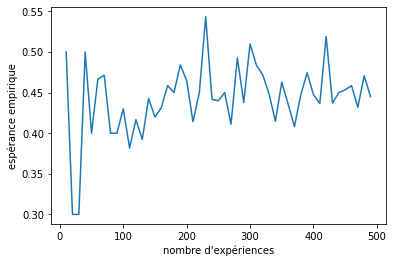

In [ ]:
# Méthode de monte-carlo
plt.plot(Index,esperance_mc)
plt.xlabel("nombre d'expériences")
plt.ylabel("espérance empirique")
plt.show()

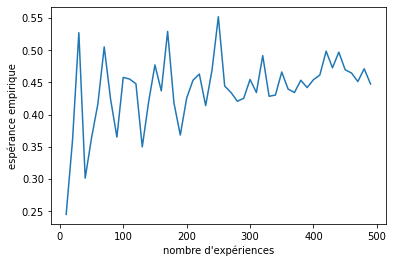

In [ ]:
# Méthode de l'échantillonnage d'importance
plt.plot(Index,esperance_is2)
plt.xlabel("nombre d'expériences")
plt.ylabel("espérance empirique")
plt.show()

## partie 3
On calcule la probabilité qu'un nombre important de points soient mal classé sachant que la relation (4) n'est presque plus satisfaite et pour faire cela on va d'abord bien choisir les paramètres tels que la probabilité de se tromper au moin une fois est de niveau 0.1 par exemple.


On commence à construire une chaîne de Markov sur l'éspace $\{0,1\}$ avec la matrice de transistion :
$$
P = \begin{pmatrix}1-v(1)*(2 - \rho)&v(1)*(2 - \rho)\\v(0)*(2 - \rho)&1 - v(0)*(2 - \rho)\end{pmatrix}
$$
où v est une mesure donnée sur l'éspace $\{0,1\}$. \\

On vérifie facilement que pour chaque étape, $X_{i+1} = X_{i}$ avec probabilité $\rho$ et la chaîne est réversible par rapport à la mesure $v$ donée. \\

Dans notre cas, on va prendre $v_1 = Ber(p_{in})$ et $v_2 = Ber(p_{out})$, et construire deux ensembles de chaînes avec la mesure stationnaire $v_1$ et $v_2$ respectivement.  \\

On note le fait que si $\{X_i\}$ et $\{Y_i\}$ sont deux chaînes indépendentes et réversibles par rapport aux mesures $u$ et $v$ repectivement , alors $\{ (X_i,Y_i) \}$ est aussi une chaîne de Markov réversible par rapport à la mesure $u*v$. Comme un graphe est décrit par sa matrice adjacente, elle même est rien d'autre que un vecteur aléatoire avec composants indépendants. On pourrait simuler chaque composant par une chaîne de Markov et puis construire une nouvelle chaîne étant la chaîne de Graphe.



In [ ]:
n = 50
p = 0.4
c_in = 40
c_out = 25
p_in = c_in/n
p_out = c_out/n
taille1 = int(n*p)
taille2 = n-taille1
size_in = int(taille1*(taille1-1)/2) + int(taille2*(taille2-1)/2)
size_out = int(taille1*taille2)
seuille = 0.3 # la seuille pour justifier "un nombre important de point soient mal classe"
rho_in = 1.2
rho_out = 1.95
P_in = np.ones(size_in)*p_in
P_out = np.ones(size_out)*p_out
print("le niveau de c_in et c_out est "+ str(niveau())  )

le niveau de c_in et c_out est 0.9406626076495193


In [ ]:
# méthode de monte carlo
N = int(100)
dataset = np.zeros(N)
for i in range(N):
  G = Graphe_(p,c_in,c_out,n)
  dataset[i] = Nbr_err_norm(G)
counts = len(dataset[dataset >= 1])
print("La probabilité d'avoir au moins une erreur par méthode de monte-carlos est "+str(counts/N))

La probabilité d'avoir au moins une erreur par méthode de monte-carlos est 0.64


In [ ]:
# La matrice de transition, le premier paramètre est X_n, le second est v dans la partie chaîne de markov 
def transition(x , v,rho_):
  v1 = v
  v0 =  1 - v1
  length = len(x)
  Y1 = sps.bernoulli.rvs(v1*(2-rho_),size = length)
  Y0 = sps.bernoulli.rvs(v0*(2-rho_),size = length)
  Z = np.zeros(length)
  #print('!!!')
  for i in range(length):
    if(x[i]==1):Z[i] = 1 - Y0[i]
    else : Z[i] = Y1[i]
  return Z

In [ ]:
## trouver le premier graphe tel que le nombre d'erreurs soit plus grand qu'un
Initiale = [] 
X_in = sps.bernoulli.rvs(P_in) 
X_out = sps.bernoulli.rvs(P_out)
X = (X_in,X_out)
for i in range(1,5):
  while(True):
    if(Nbr_err_norm(Graphe(X[0],X[1])) >= i):
      Initiale.append(X);
      break
    X_in = transition(X_in,p_in,rho_in)
    X_out = transition(X_out,p_out,rho_out)
    X = (X_in,X_out)
# un exemple pour illustrer l'idée :
X_in = np.zeros(size_in) # un cas extrême, pas de ligne 
X_out = np.zeros(size_out) + 1



In [ ]:
# On pense à calculer la proba que le nombre d'erreurs soient plus grand qu'un
# par défaut, rho_in = rho _out = 1.5
def spliting(p_in_, p_out_, nombre, N_, rho_in_ = 1.5 , rho_out_ = 1.5): 
  ## trouver les valeurs initiales pour les chaînes 
  rho_in = rho_in_
  rho_out = rho_out_
  print('rho_in = '+str(rho_in))
  print('rho_out = '+str(rho_out))
  # Constuire la chaîne
  N = N_
  P_in = np.ones(size_in)*p_in_
  P_out = np.ones(size_out)*p_out_
  P = np.append(P_in,P_out)
  # initialisation
  X_in = sps.bernoulli.rvs(P_in) 
  X_out = sps.bernoulli.rvs(P_out)
  X = (X_in,X_out)
  G = Graphe(X_in,X_out)
  chaine_graphe = [G]
  chaine_vecteur = [X]

  for i in range(N):
    X_in = transition(X_in,p_in_,rho_in)
    X_out = transition(X_out,p_out_,rho_out)
    X = (X_in,X_out)
    G = Graphe(X_in,X_out)
    chaine_graphe.append(G)
    chaine_vecteur.append(X)

  P = [Nbr_err_norm(X)>0 for X in chaine_graphe]
  Proba = [np.mean(P)]
  print('!!!')
  ## spliting
  for i in range(1,nombre):
    print('voici les résultats du '+ str(i) + 'ème chaîne')

    NBR = np.zeros(N+1)
    Rejet = np.zeros(N) # ce tableau enregistre le processus de rejet 
    NBR[0] = i #ce tableau contient les nombres d'erreurs pour chaque expérience
    X_in,X_out = Initiale[i-1]
    #X_in = np.zeros(size_in)
    #X_out = 1 + np.zeros(size_out)
    ## faire évoluer la chaîne par rejet:
    for j in range(N):
      X_in = transition(X_in,p_in_,rho_in)
      X_out = transition(X_out,p_out_,rho_out)
      G = Graphe(X_in,X_out)
      temp = Nbr_err_norm(G)
      if(temp>=i):
        chaine_vecteur.append(X)
        chaine_graphe.append(G)
        NBR[j+1] = temp 
        Rejet[j] = 0
      else : 
        chaine_vecteur.append(chaine_vecteur[-1])
        chaine_graphe.append(chaine_graphe[-1])
        NBR[j+1] = NBR[j]
        Rejet[j] = 1
    P = NBR > i
    Proba.append(np.mean(P))
    proba = np.prod(Proba)
    
    print('on enregistre les nombre erreur pour chaque élement de la chaîne')
    print(NBR)
    print('on enregistre le processus de rejet, 1 reprensente rejet, 0 sinon')
    print(Rejet)
    NBRJ = np.sum(Rejet==1)
    print('le nombre de rejet est '+str(NBRJ))
  return Proba 


In [ ]:
Proba = spliting(p_in, p_out,5,200,rho_out_= 1.9,rho_in_ = 1.)
print('le tablaux qui contient les 5 probas')
print(Proba)
print('la probabilité que plus de 5 points mal-classé est '+str(np.prod(Proba)))

rho_in = 1.0
rho_out = 1.9
!!!
voici les résultats du 1ème chaîne
on enregistre les nombre erreur pour chaque élement de la chaîne
[1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 4. 5. 2. 2. 3. 3. 1. 2. 2. 1. 2. 1.
 3. 3. 2. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 3.
 2. 2. 2. 3. 3. 3. 2. 3. 3. 1. 1. 3. 3. 3. 3. 3. 3. 1. 3. 3. 1. 1. 1. 1.
 1. 2. 2. 1. 2. 3. 1. 2. 3. 1. 1. 1. 1. 1. 2. 1. 7. 3. 2. 1. 2. 2. 2. 1.
 1. 2. 2. 1. 5. 1. 3. 1. 1. 1. 2. 3. 2. 1. 3. 3. 2. 2. 2. 3. 4. 2. 2. 1.
 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 1. 1. 2. 2. 3. 1. 2. 2.
 2. 2. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 6. 2. 2.
 2. 2. 1. 1. 2. 1. 1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 2. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
on enregistre le processus de rejet, 1 reprensente rejet, 0 sinon
[1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1

In [ ]:
# test du programme pour la proba que plus de 2 élénts soient mal-classés
c_in = 40
c_out = 22
p_in = c_in/n
p_out = c_out/n
taille1 = int(n*p)
taille2 = n-taille1
size_in = int(taille1*(taille1-1)/2) + int(taille2*(taille2-1)/2)
size_out = int(taille1*taille2)
rho = 1.5
P_in = np.ones(size_in)*p_in
P_out = np.ones(size_out)*p_out
print("le niveau de c_in et c_out est "+ str(niveau())  )
# par méthode de monte-carlo
N = int(200)
dataset = np.zeros(N)
for i in range(N):
  G = Graphe_(p,c_in,c_out,n)
  dataset[i] = Nbr_err_norm(G)
counts = len(dataset[dataset >= 2])
print("La probabilité d'avoir au moins deux erreurs est par méthode de monte-carlo est "+str(counts/N))

proba = np.prod(spliting(p_in,p_out,2,N))
print("La probabilité d'avoir au moins deux erreurs est par méthode de spliting est "+str(proba))

le niveau de c_in et c_out est 1.155782089894163
La probabilité d'avoir au moins deux erreurs est par méthode de monte-carlo est 0.055
rho_in = 1.5
rho_out = 1.5
!!!
voici les résultats du 1ème chaîne
on enregistre les nombre erreur pour chaque élement de la chaîne
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 3. 2. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 3. 3. 3. 2. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
on enregistre le processus de rejet, 1 reprensente rejet, 0 sinon
[0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 